In [17]:
import os, sys

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
sys.path.append(str(Path.cwd().resolve().parent))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import weight_norm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_percentage_error

from preprocess import VN30, TARGETS, preprocess_v2

In [ ]:
symbol = 'ACB'

# Bước 1: Tiền xử lý dữ liệu

In [ ]:
train_loader, valid_loader, test_loader, scaler = preprocess_v2(symbol, 'cnn', verbose=True)

Train shape: torch.Size([1094, 4, 30]), torch.Size([1094, 4])
Valid shape: torch.Size([121, 4, 30]), torch.Size([121, 4])


# Bước 2: Định nghĩa mô hình

In [16]:
class TCN(nn.Module):
    def __init__(self, n_channels=5, window_size=30, hidden_dim=64, output_dim=5, p_dropout=0.2):
        super().__init__()
        # Conv block với BatchNorm + Dropout
        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels=n_channels, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p_dropout),

            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p_dropout),
        )
        # Global pooling
        self.pool = nn.AdaptiveAvgPool1d(1)  # gom về (batch, 64, 1)

        # MLP head với thêm dropout
        self.fc = nn.Sequential(
            nn.Linear(64, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        # x: (batch, n_channels, window_size)
        x = self.conv_block(x)       # → (batch, 64, window_size)
        x = self.pool(x).squeeze(-1) # → (batch, 64)
        x = self.fc(x)               # → (batch, output_dim)
        return x

# Bước 3: Huấn luyện mô hình

In [ ]:
os.makedirs('checkpoints', exist_ok=True)
checkpoint_path = f'checkpoints/tcn_{symbol}.pth'

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TCN(
    n_channels=4,
    window_size=30,
    hidden_dim=256,
    output_dim=4,
    p_dropout=0.1
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

In [51]:
best_val_loss = float('inf')
num_epochs = 100

for epoch in range(1, num_epochs + 1):
    # --- train ---
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss  = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)

    # --- validate ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            val_loss += criterion(preds, y_batch).item() * X_batch.size(0)
    val_loss /= len(valid_loader.dataset)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:02d}: train_loss={train_loss:.6f}, val_loss={val_loss:.6f}")

    # --- checkpoint ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_path)
        print(f"  → Saved checkpoint | val_loss={val_loss:.6f}")

  → Saved checkpoint | val_loss=0.012546
  → Saved checkpoint | val_loss=0.009114
Epoch 10: train_loss=0.032492, val_loss=0.079728
  → Saved checkpoint | val_loss=0.005862
  → Saved checkpoint | val_loss=0.005747
Epoch 20: train_loss=0.018751, val_loss=0.042033
  → Saved checkpoint | val_loss=0.003325
Epoch 30: train_loss=0.018539, val_loss=0.007241
  → Saved checkpoint | val_loss=0.003247
  → Saved checkpoint | val_loss=0.002507
Epoch 40: train_loss=0.019202, val_loss=0.003445
Epoch 50: train_loss=0.015417, val_loss=0.003426
  → Saved checkpoint | val_loss=0.002336
Epoch 60: train_loss=0.014592, val_loss=0.004014
Epoch 70: train_loss=0.013786, val_loss=0.031248
Epoch 80: train_loss=0.010671, val_loss=0.009552
  → Saved checkpoint | val_loss=0.002317
Epoch 90: train_loss=0.010837, val_loss=0.003502
  → Saved checkpoint | val_loss=0.002218
Epoch 100: train_loss=0.010142, val_loss=0.007092


In [52]:
# Load model
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

# Thu thập dự đoán và nhãn
all_preds   = []
all_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(y_batch.numpy())

all_preds   = np.vstack(all_preds)   # (n_samples, 5)
all_targets = np.vstack(all_targets)

# Inverse scaling
all_preds_inv   = scaler.inverse_transform(all_preds)
all_targets_inv = scaler.inverse_transform(all_targets)

# Tính metrics
r2   = r2_score(all_targets_inv, all_preds_inv, multioutput='uniform_average')
mape = mean_absolute_percentage_error(all_targets_inv, all_preds_inv) * 100

print(f"Test R²: {r2:.4f}")
print(f"Test MAPE: {mape:.4f}%")

Test R²: 0.8774
Test MAPE: 1.1659%


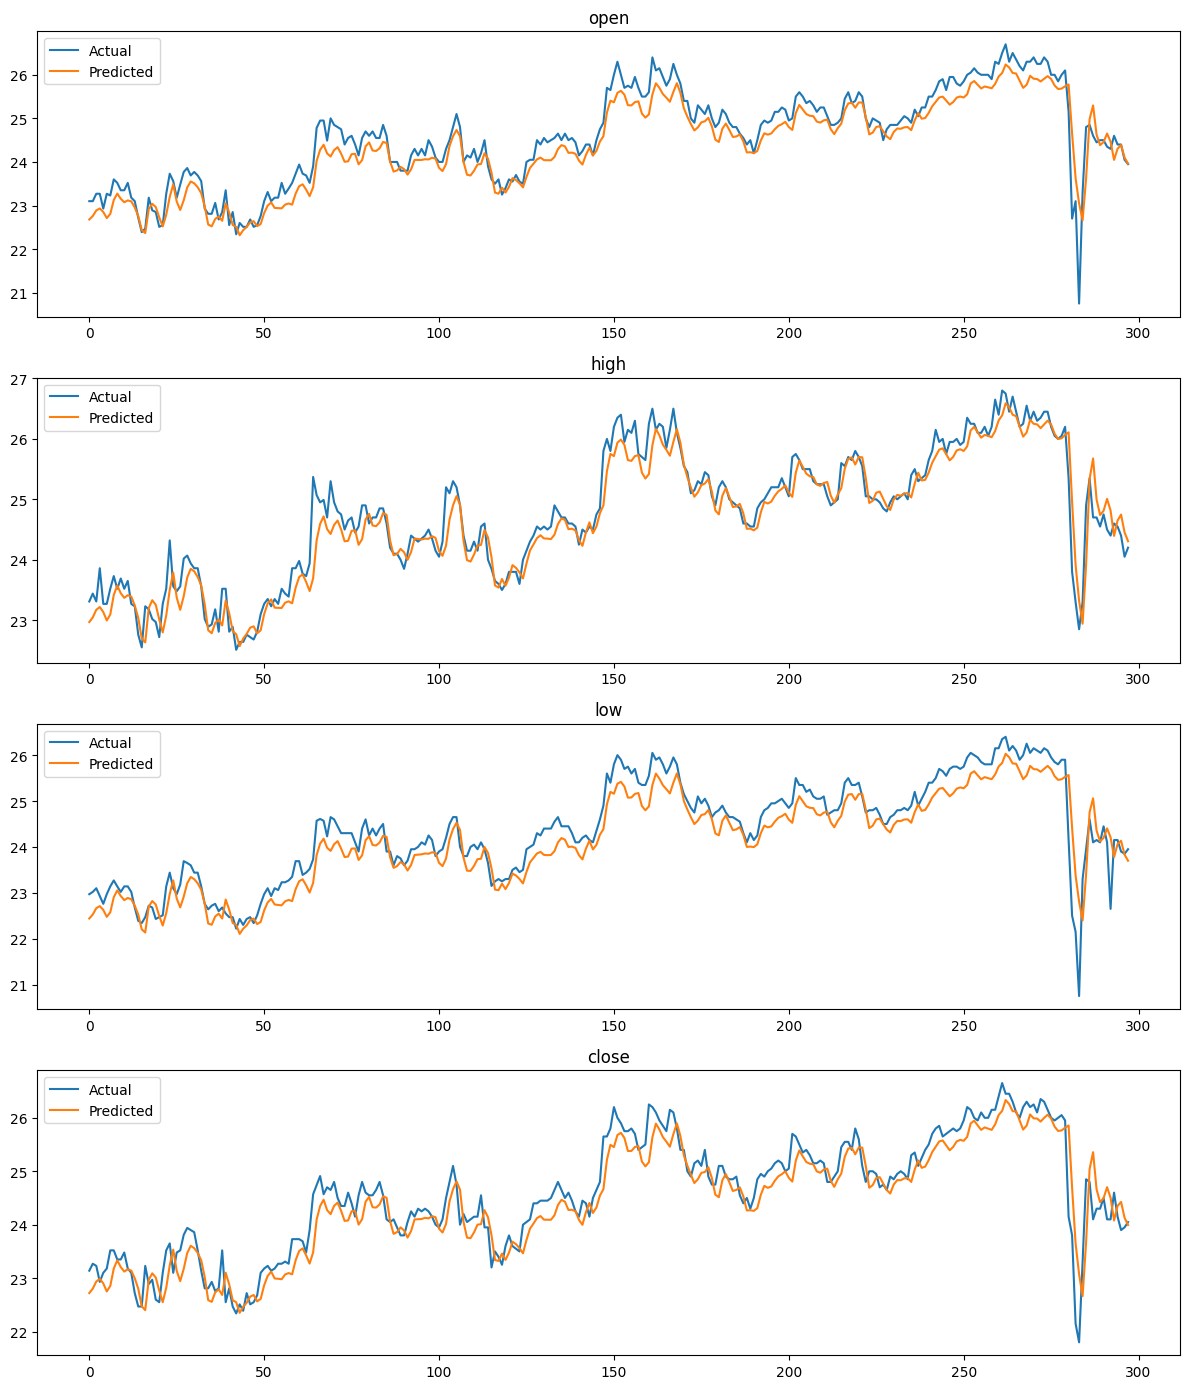

In [53]:
n = all_targets_inv.shape[1]

plt.figure(figsize=(12, 14))
for i in range(n):
    ax = plt.subplot(n, 1, i + 1)
    ax.plot(all_targets_inv[:, i], label='Actual')
    ax.plot(all_preds_inv[:, i],   label='Predicted')
    ax.set_title(TARGETS[i])
    ax.legend(loc='best')

plt.tight_layout()
plt.show()